In [2]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os
from astropy.cosmology import WMAP9 as cosmo


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo


In [357]:
def read_q(z,rad_flux):
    #functiont to return the predicted fir flux of an object when given its redshift and radio flux at 150MHz 
    #using teh relation from Read et al 2018
    dist = cosmo.luminosity_distance(z).to(u.m).value
    alpha = -0.7
    rad_lum = rad_flux*4*np.pi*dist**2 * (1+z)**(-1-alpha)
    
    q_pred = 1.6-z
    
    fir_lum = 10**(q_pred + np.log10(rad_lum))
    fir_flux = fir_lum/(4*np.pi*dist**2)
    return(fir_flux)

In [4]:
def get_gaus_prior_250(z,f_rad):
    q = 10**(-0.0467*z-1.7483)
    f_ir = f_rad/q*1000
    
    q_up = -0.0467*z-1.7483 + 2*0.2375
    f_up = (f_rad/(10**q_up))*1000
    q_low = -0.0467*z-1.7483 - 2*0.2375
    f_low = (f_rad/(10**q_low))*1000
    
    f_mean = (f_up+f_low)/2
    sig = abs((f_up - f_low)/2)
    return(f_mean,sig)

In [5]:
def get_gaus_prior_350(z):
    return(-0.1418*z-1.4567)

In [6]:
def get_gaus_prior_500(z):
    return(-0.2345*z-1.0)

#This cell is now outdated with the newer catalogue releases

#Read in the LOFAR data both optical and radio
lofar_rad = Table.read('data/radio/EN1_ML_RUN_fin_overlap_srl_workflow.fits')
lofar_opt = Table.read('data/optical/EN1_MASTER_opt_spitzer_merged_cedit_apcorr.fits')
lofar_opt.rename_column('ALPHA_J2000','ra')
lofar_opt.rename_column('DELTA_J2000','dec')

#merge the optical and radio catalogue to find out which optical sources need crossmatching to HELP
mask = ~np.isnan(lofar_rad['lr_index_fin'])
lofar = hstack([lofar_rad[mask],lofar_opt[lofar_rad[mask]['lr_index_fin'].astype(int)]])

In [120]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
#mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
#lofar = lofar[~mask]

print(len(lofar))      

31645


In [170]:
lingyu_ir_results = Table.read('data/IR_lum_sources_lingyu/lingyu_en1/multi_en1_18_final_overlap.fits')
lingyu_ir_results.remove_column('help_id')
lingyu_ir_results.rename_column('Source_Name','help_id')
lingyu_ir_results[0]

index_SPIRE,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,RA_pix,Dec_pix,Source_id,RA_lofar_b,DEC_lofar_b,Total_flux_1,E_Total_flux_1,GroupID,GroupSize,Separation_1,help_id,RA_lofar_f,DEC_lofar_f,Total_flux_2,E_Total_flux_2,Peak_flux,E_Peak_flux,flag_clean,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,g_flux_corr,g_fluxerr_corr,r_flux_corr,r_fluxerr_corr,i_flux_corr,i_fluxerr_corr,z_flux_corr,z_fluxerr_corr,y_flux_corr,y_fluxerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,J_flux_corr,J_fluxerr_corr,K_flux_corr,K_fluxerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,Separation_2,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,chi_r_best,AGN,optAGN,IRAGN,XrayAGN,Mass_median,Separation
,Jy,Jy,Jy,Jy,Jy,Jy,deg,deg,,deg,deg,Jy,Jy,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,int32,float64,bytes22,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,bool,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float32,float64
10,0.3405048033149008,0.004063303381706123,0.1463972048645392,0.004197150586218821,0.056075692995148654,0.004603881568652193,244.18941210376144,55.04219952337906,23351,244.19199009883337,55.042466021782786,0.006981056990590427,4.276536874892677e-05,1,2,5.403472523181291,ILTJ161646.08+550232.8,244.19199009883337,55.042466021782786,0.006981056990590427,4.276536874892677e-05,0.006364762174386892,2.3199684597677185e-05,1,7,65.03035736083984,0.1246112659573555,257.3834228515625,0.11351067572832108,517.8934936523438,0.1560952067375183,766.5390014648438,0.187179833650589,961.4060668945312,0.2664457857608795,1118.1488037109375,0.80076664686203,272.1108093261719,0.08557576686143875,546.9458618164062,0.15268200635910034,520.5745239257812,0.19987009465694427,1002.5556030273438,0.3397477865219116,1038.096435546875,0.7089093327522278,1034.993896484375,0.2708333134651184,1271.9603271484375,0.8975200653076172,1420.830322265625,1.304610013961792,910.4151000976562,6.847447292939963,620.7652587890625,5.491953246747257,442.2200622558594,10.765911496383444,478.4780578613281,10.650620475330449,nan,nan,nan,nan,0.0,0.028565709,699.05853,717.43054,680.62463,True,38.026817,50.999832,24.876867,52.89416,71.73796,35.928127,False,False,30.625317,35.568714,25.421791,2.9472263,6.8641367,0.8475419,11.721847,23.944975,3.6669765,0.08364844,1.0,nan,0.054,0.0,0.1,0.751,nan,nan,nan,nan,1.669176,0,0.0,0.0,0.0,10.420248,0.0


In [119]:
lingyu_prior = Table.read('data/IR_lum_sources_lingyu/lingyu_en1/en1_for_build_prior.txt',format='ascii')
lingyu_prior['Source_Name'][2]

'ILTJ160440.64+553409.3'

In [264]:
ids = lingyu_ir_results['help_id'][10:60]

ras = lingyu_ir_results['RA_lofar_f'][10:60]
decs = lingyu_ir_results['DEC_lofar_f'][10:60]
ras

243.81052648713336
244.63570320122855
244.6325709346501
244.62830985485328
243.86699984007356
243.86405136749298
244.53061259265468
243.57476229776506
240.1617453918961
243.86554455087295
243.86252862510466


In [265]:
#Read in the herschel images
imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'

pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits=imfolder+'ELAIS-N1_SPIRE350_v1.0.fits'#SPIRE 350 map
plwfits=imfolder+'ELAIS-N1_SPIRE500_v1.0.fits'#SPIRE 500 map

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
nim250=hdulist['error'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['image'].header

im350=hdulist['image'].data*1.0E3 #convert to mJy
nim350=hdulist['error'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['image'].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['image'].header 
im500=hdulist['image'].data*1.0E3 #convert to mJy
nim500=hdulist['error'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist['image'].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [266]:
prior_cat = Table.read('data/data_release/xidplus_prior_cat.fits')
prior_cat[0]

ra,dec,help_id,flag_optnir_det,f_mips_24
deg,deg,,,
float64,float64,bytes1728,float64,float64
239.086706815057,54.8536967354993,HELP_J155620.810+545113.308,7.0,272.37057


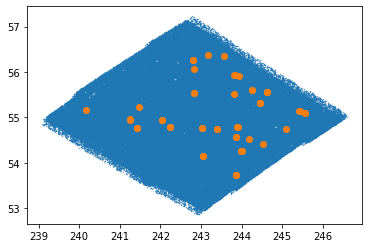

In [267]:
x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=0.1)

plt.scatter(ras,decs)
plt.show()

In [268]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,60,15)

ras_prior = prior_cat['ra']
decs_prior = prior_cat['dec']
mask = inMoc(ras_prior,decs_prior,moc)
prior_cat = prior_cat[mask]

In [205]:
print(len(prior_cat))
np.isin(ids,prior_cat['help_id'])

180


array([ True,  True, False,  True,  True, False, False,  True, False,
       False])

In [340]:
f_mean,f_sig = get_gaus_prior_250(lingyu_ir_results['Z_BEST'][10:60],lingyu_ir_results['Total_flux_1'][10:60])
f_sig = f_sig*10

In [341]:
np.min(f_sig)

112.65110972339608

#Get flux priors for the sources
f_mean = np.zeros(len(prior_cat))
mask = np.array(['ILTJ' in name for name in prior_cat['help_id']])
mask_name = np.array([name in prior_cat['help_id'] for name in lofar['Source_Name']])


f_sig = np.zeros(len(prior_cat)) + 0.1
mask = np.array(['ILTJ' in name for name in prior_cat['help_id']])
f_mean[mask],f_sig[mask] = get_gaus_prior_250(lofar[mask_name]['Z_BEST'],lofar[mask_name]['Total_flux'])

print(f_mean)
print(f_sig)

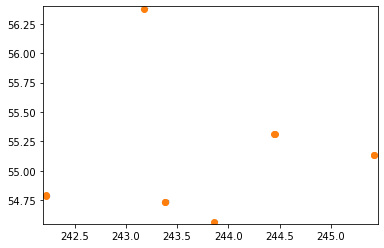

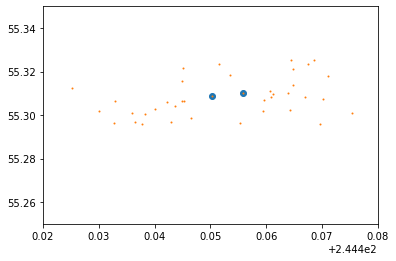

In [188]:
x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=0.1)

plt.scatter(ras,decs)

#plt.scatter(x,y,s=f_mean)

#plt.scatter(ras,decs)
plt.xlim(np.min(x)-0.005,np.max(x)+0.005)
plt.ylim(np.min(y)-0.005,np.max(y)+0.005)
plt.show()


plt.scatter(ras,decs)
x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=1)

#plt.scatter(ras,decs)
plt.xlim(244.42,244.48)
plt.ylim(55.25,55.35)
plt.show()


In [342]:
prior250.prior_flux_sigma = f_sig

In [149]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'],flux_mu=f_mean, flux_sigma=f_sig)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'],flux_mu=f_mean, flux_sigma=f_sig)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'],flux_mu=f_mean, flux_sigma=f_sig)
prior500.prior_bkg(-5.0,5)

In [270]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(ras,decs,'prior_cat',ID=ids,flux_mu=f_mean, flux_sigma=f_sig)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(ras,decs,'prior_cat',ID=ids,flux_mu=f_mean, flux_sigma=f_sig)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(ras,decs,'prior_cat',ID=ids,flux_mu=f_mean, flux_sigma=f_sig)
prior500.prior_bkg(-5.0,5)

In [ ]:
'''#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])
prior500.prior_bkg(-5.0,5)'''

In [271]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires PRF as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [272]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')



fitting 50 sources 

using 6181, 3213 and 1556 pixels


In [273]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()

In [274]:
prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

In [275]:
mask = np.array(['ILTJ' in prior250.ID[i] for i in range(len(prior250.ID)) ])
print(np.sum(mask))
tmp = prior250.ID[mask]
mask = np.array([name in ids for name in tmp])
tmp[mask]

50


ILTJ161514.53+553053.6
ILTJ161832.57+553408.6
ILTJ161831.82+553357.9
ILTJ161830.79+553402.1
ILTJ161528.08+534402.1
ILTJ161527.37+534347.1
ILTJ161807.35+542419.8
ILTJ161417.94+562125.8
ILTJ160038.82+551018.4
ILTJ161527.73+543413.4
ILTJ161527.01+543354.8


In [343]:
from xidplus.stan_fit import SPIRE
fit_gaus=SPIRE.all_bands_gaussian(prior250,prior350,prior500,iter=1000)
fit_flat=SPIRE.all_bands(prior250,prior350,prior500,iter=1000)

reading file in <_io.BufferedReader name='/lustre/scratch/astro/im281/FIR-group/Ian/lofar/deep_fields/ELAIS-N1/XID+SPIRE_gaussian.pkl'>
/XID+SPIRE_gaussian found. Reusing
reading file in <_io.BufferedReader name='/lustre/scratch/astro/im281/FIR-group/Ian/lofar/deep_fields/ELAIS-N1/XID+SPIRE.pkl'>
/XID+SPIRE found. Reusing


In [345]:
posterior_gaus=xidplus.posterior_stan(fit_gaus,[prior250,prior350,prior500])
posterior_flat=xidplus.posterior_stan(fit_flat,[prior250,prior350,prior500])

In [346]:
priors = [prior250,prior350,prior500]

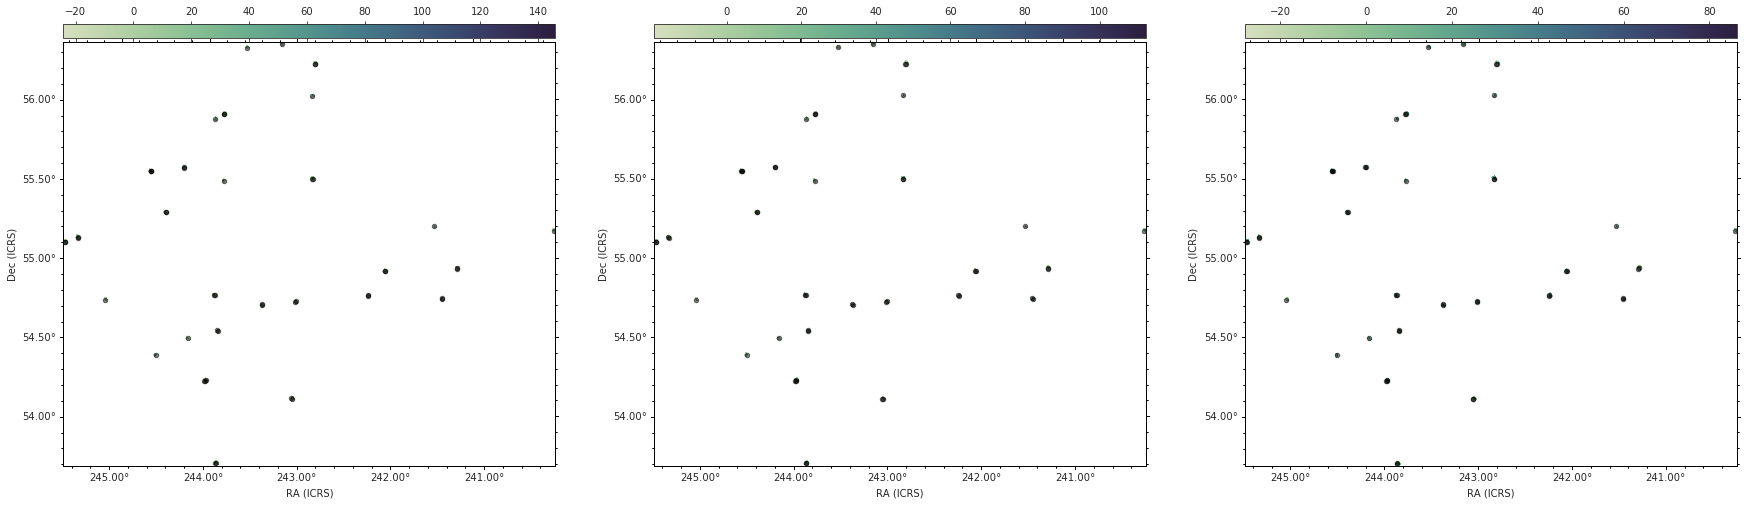

In [279]:
figs,fig=xidplus.plot_map(priors)

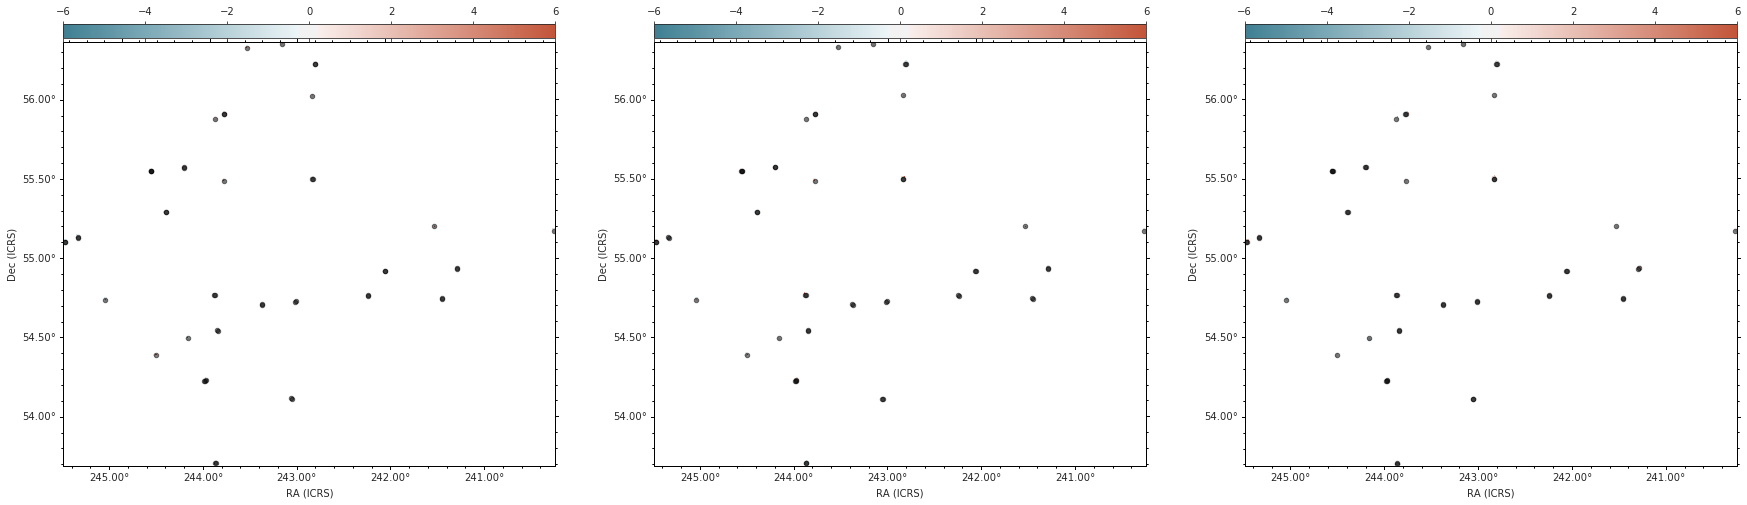

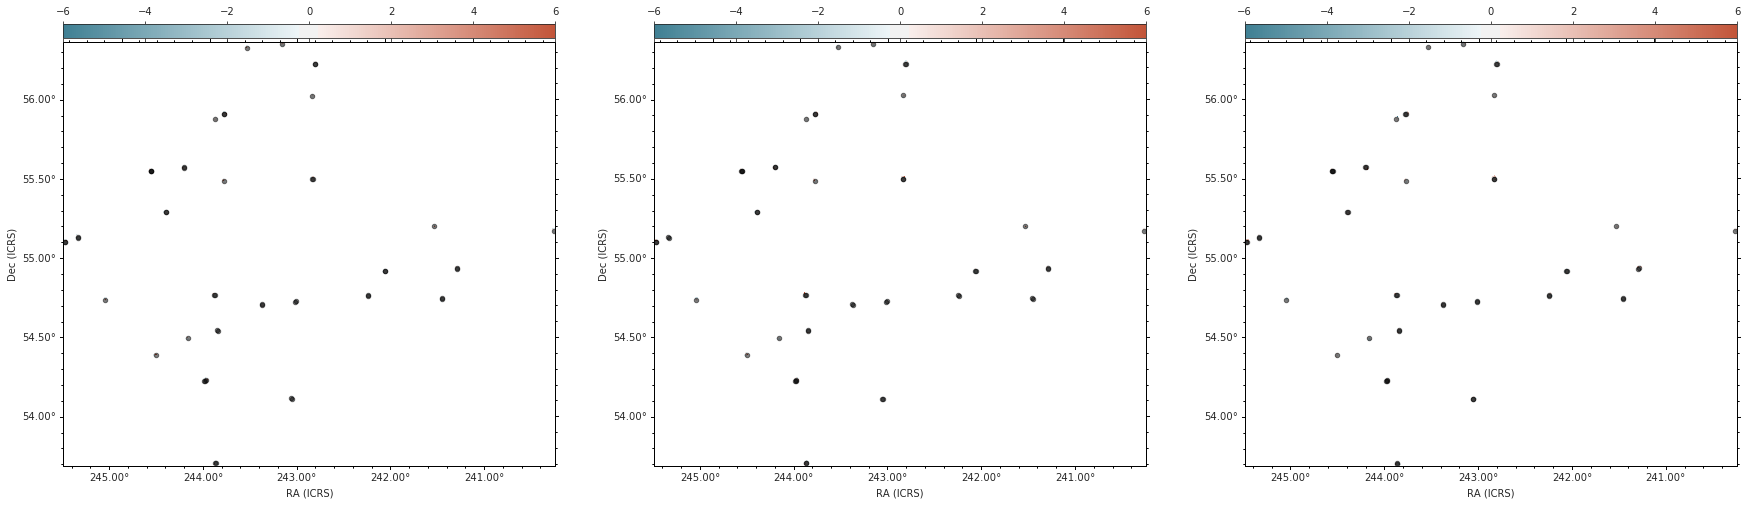

In [280]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior_gaus)
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior_flat)

In [347]:
prior_table = Table()
col_id = Column(name='help_id',data=prior250.ID)
col_mu = Column(name='prior_flux',data=prior250.prior_flux_mu)
prior_table.add_columns([col_id,col_mu])

import xidplus.catalogue as cat
SPIRE_cat_gaus=cat.create_SPIRE_cat(posterior_gaus,priors[0],priors[1],priors[2])
SPIRE_cat_gaus = Table.read(SPIRE_cat_gaus)
SPIRE_cat_gaus.rename_column('HELP_ID','help_id')
mask = np.array(['ILTJ' in name for name in SPIRE_cat_gaus['help_id']])
SPIRE_cat_gaus = SPIRE_cat_gaus[mask]
SPIRE_cat_gaus = join(SPIRE_cat_gaus,prior_table,keys='help_id')
print(len(SPIRE_cat_gaus))

SPIRE_cat_flat=cat.create_SPIRE_cat(posterior_flat,priors[0],priors[1],priors[2])
SPIRE_cat_flat = Table.read(SPIRE_cat_flat)
SPIRE_cat_flat.rename_column('HELP_ID','help_id')
mask = np.array(['ILTJ' in name for name in SPIRE_cat_flat['help_id']])
SPIRE_cat_flat = SPIRE_cat_flat[mask]
SPIRE_cat_flat = join(SPIRE_cat_flat,prior_table,keys='help_id')
print(len(SPIRE_cat_flat))

50
50


In [ ]:
help_XID = Table.read('../../../../../HELP/dmu_products/dmu26/dmu26_XID+SPIRE_ELAIS-N1/data/dmu26_XID+SPIRE_ELAIS-N1_SWIRE_cat_20170808.fits')

help_XID = Table.read('../../../../../HELP/dmu_products/dmu26/dmu26_XID+SPIRE_ELAIS-N1/data/dmu26_XID+SPIRE_ELAIS-N1_SERVS_cat_20170725.fits')

joined = join(SPIRE_cat,help_XID,join_type='inner',keys='help_id')
print(len(joined))

x = np.log10(joined['F_SPIRE_250_2'])
xerr_u = np.log10(joined['FErr_SPIRE_250_u_2']-joined['F_SPIRE_250_2'])
yerr_l = np.log10(joined['F_SPIRE_250_2']-joined['FErr_SPIRE_250_l_2'])
y = np.log10(joined['F_SPIRE_250_1'])
yerr_u = np.log10(joined['FErr_SPIRE_250_u_1']-joined['F_SPIRE_250_1'])
yerr_l = np.log10(joined['F_SPIRE_250_1']-joined['FErr_SPIRE_250_l_1'])

#plt.errorbar(x,y,xerr=xerr,yerr=[yerr_u,yerr_l],linestyle='')
plt.scatter(x,y,s=1)
plt.plot([0,4],[0,4],c='black')
plt.xlabel('HELP')
plt.ylabel('gauss prior')
plt.title('log 250um')
plt.show()

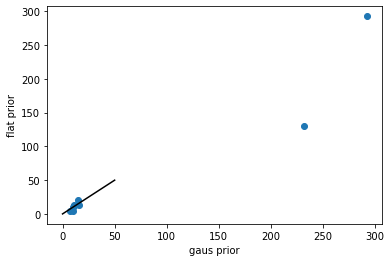

In [36]:
SPIRE_cat_join = join(SPIRE_cat_gaus,SPIRE_cat_flat,keys='help_id')
mask = np.array(['ILTJ' in name for name in SPIRE_cat_join['help_id']])
x = SPIRE_cat_join['F_SPIRE_250_1'][mask]
y = SPIRE_cat_join['F_SPIRE_250_2'][mask]

plt.scatter(x,y)
plt.plot([0,50],[0,50],c='black')
plt.xlabel('gaus prior')
plt.ylabel('flat prior')
plt.show()

In [257]:
modifier = []
x_list = []
y_list = []

In [370]:
lingyu_ir_results[0]

index_SPIRE,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,RA_pix,Dec_pix,Source_id,RA_lofar_b,DEC_lofar_b,Total_flux_1,E_Total_flux_1,GroupID,GroupSize,Separation_1,help_id,RA_lofar_f,DEC_lofar_f,Total_flux_2,E_Total_flux_2,Peak_flux,E_Peak_flux,flag_clean,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,g_flux_corr,g_fluxerr_corr,r_flux_corr,r_fluxerr_corr,i_flux_corr,i_fluxerr_corr,z_flux_corr,z_fluxerr_corr,y_flux_corr,y_fluxerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,J_flux_corr,J_fluxerr_corr,K_flux_corr,K_fluxerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,Separation_2,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,chi_r_best,AGN,optAGN,IRAGN,XrayAGN,Mass_median,Separation
,Jy,Jy,Jy,Jy,Jy,Jy,deg,deg,,deg,deg,Jy,Jy,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,int32,float64,str22,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,bool,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float32,float64
10,0.3405048033149008,0.004063303381706123,0.1463972048645392,0.004197150586218821,0.056075692995148654,0.004603881568652193,244.18941210376144,55.04219952337906,23351,244.19199009883337,55.042466021782786,0.006981056990590427,4.276536874892677e-05,1,2,5.403472523181291,ILTJ161646.08+550232.8,244.19199009883337,55.042466021782786,0.006981056990590427,4.276536874892677e-05,0.006364762174386892,2.3199684597677185e-05,1,7,65.03035736083984,0.1246112659573555,257.3834228515625,0.11351067572832108,517.8934936523438,0.1560952067375183,766.5390014648438,0.187179833650589,961.4060668945312,0.2664457857608795,1118.1488037109375,0.80076664686203,272.1108093261719,0.08557576686143875,546.9458618164062,0.15268200635910034,520.5745239257812,0.19987009465694427,1002.5556030273438,0.3397477865219116,1038.096435546875,0.7089093327522278,1034.993896484375,0.2708333134651184,1271.9603271484375,0.8975200653076172,1420.830322265625,1.304610013961792,910.4151000976562,6.847447292939963,620.7652587890625,5.491953246747257,442.2200622558594,10.765911496383444,478.4780578613281,10.650620475330449,nan,nan,nan,nan,0.0,0.028565709,699.05853,717.43054,680.62463,True,38.026817,50.999832,24.876867,52.89416,71.73796,35.928127,False,False,30.625317,35.568714,25.421791,2.9472263,6.8641367,0.8475419,11.721847,23.944975,3.6669765,0.08364844,1.0,nan,0.054,0.0,0.1,0.751,nan,nan,nan,nan,1.669176,0,0.0,0.0,0.0,10.420248,0.0


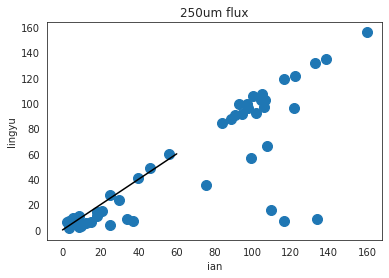

In [348]:
lingyu_ir_results = Table.read('data/IR_lum_sources_lingyu/lingyu_en1/multi_en1_18_final_overlap.fits', character_as_bytes=False)
lingyu_ir_results.remove_column('help_id')
lingyu_ir_results.rename_column('Source_Name','help_id')
lingyu_ir_results['help_id'] = lingyu_ir_results['help_id'].astype(str)
lingyu_XID_join = join(SPIRE_cat_gaus,lingyu_ir_results,keys='help_id')


mask = np.array(['ILTJ' in name for name in SPIRE_cat_gaus['help_id']])
ras = SPIRE_cat_gaus['RA'][mask].data
decs = SPIRE_cat_gaus['Dec'][mask].data
SPIRE_coords = SkyCoord(ra=ras*u.degree,dec=decs*u.degree)
ras = lingyu_ir_results['RA_lofar_b'].data
decs = lingyu_ir_results['DEC_lofar_b'].data
lingyu_coords = SkyCoord(ra=ras*u.degree,dec=decs*u.degree)

idx,d2d,_ = SPIRE_coords.match_to_catalog_sky(lingyu_coords)

mask_d2d = d2d.value*3600<5
lingyu_XID_join = join(SPIRE_cat_gaus[mask],lingyu_ir_results,table_names=['XID','lingyu'],keys='help_id')
x = lingyu_XID_join['F_SPIRE_250_XID']
y = lingyu_XID_join['F_SPIRE_250_lingyu']
plt.scatter(x,y,s=100)
plt.plot([0,60],[0,60],c='black')
plt.xlabel('ian')
plt.ylabel('lingyu')
plt.title('250um flux')
plt.show()

modifier.append(10.0)
x_list.append(x)
y_list.append(y)

In [352]:
modifier

[1.5, 0.5, 0.1, 0.03, 1.0, 10.0]

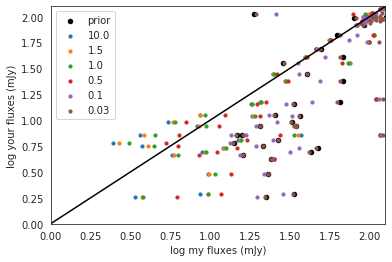

In [356]:
x = np.log10(lingyu_XID_join['prior_flux'])
xerr = 
y = np.log10(y_list[0])
plt.scatter(x,y,s=20,c='black',label='prior')
plt.errorbar(x,y,xerr=[])
for n in [5,0,4,1,2,3]:
    x = np.log10(x_list[n])
    y = np.log10(y_list[n])
    plt.scatter(x,y,s=10,label=str(modifier[n]))
    
plt.plot([0,170],[0,170],c='black')
plt.xlim(0,2.1)
plt.ylim(0,2.1)
plt.xlabel('log my fluxes (mJy)')
plt.ylabel('log your fluxes (mJy)')
plt.legend()
plt.show()

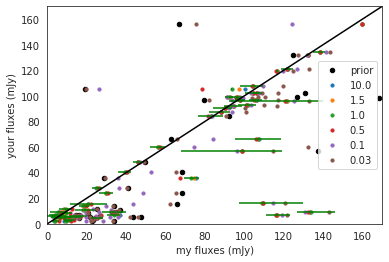

In [369]:
x = lingyu_XID_join['prior_flux']
y = y_list[0]
plt.scatter(x,y,s=20,c='black',label='prior')
for n in [5,0,4,1,2,3]:
    x = x_list[n]
    y = y_list[n]
    plt.scatter(x,y,s=10,label=str(modifier[n]))
    if n==4:
        yerr_u = lingyu_XID_join['FErr_SPIRE_250_u_lingyu'] - y
        yerr_l = y - lingyu_XID_join['FErr_SPIRE_250_l_lingyu']
        plt.errorbar(x,y,xerr=[yerr_l,yerr_u],ls='',c='green')
    
plt.plot([0,170],[0,170],c='black')
plt.xlim(0,170)
plt.ylim(0,170)
plt.xlabel('my fluxes (mJy)')
plt.ylabel('your fluxes (mJy)')
plt.legend()
plt.show()

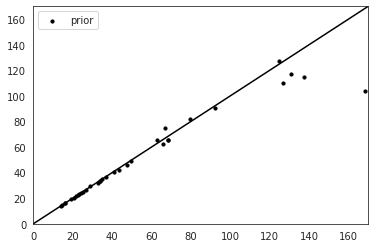

In [325]:
plt.scatter(f_mean,SPIRE_cat_gaus['F_SPIRE_250'],s=10,c='black',label='prior')
#for n in range(len(modifier)):
    
#    plt.scatter(x_list[n],y_list[n],s=10,label=str(modifier[n]))
    
plt.plot([0,170],[0,170],c='black')
plt.xlim(0,170)
plt.ylim(0,170)
plt.legend()
plt.show()

In [78]:
SPIRE_cat_gaus['help_id'][mask]

ILTJ160410.33+552444.8
ILTJ160410.35+545847.1
ILTJ160411.97+545805.4
ILTJ160413.71+545821.0
ILTJ160603.52+552529.2
ILTJ160609.76+552458.4
ILTJ161252.75+545443.0
ILTJ161254.20+545525.8
ILTJ161656.71+560026.9


In [165]:
names_used

ILTJ161527.01+543354.8
ILTJ161748.06+551831.0
ILTJ161749.40+551836.8
ILTJ162142.05+550808.2
ILTJ162140.75+550800.1
ILTJ160853.97+544735.4
ILTJ160853.55+544719.8
ILTJ161242.15+562242.4
ILTJ161332.78+544413.9
ILTJ161331.73+544358.7


In [166]:
SPIRE_cat_gaus['help_id']

ILTJ160852.83+544640.6
ILTJ160856.34+544757.9
ILTJ161242.41+562241.8
ILTJ161328.17+544431.1
ILTJ161331.73+544358.7
ILTJ161530.40+543317.7
ILTJ161531.19+543441.4
ILTJ161533.27+543351.0
ILTJ161746.79+551822.6
ILTJ162145.13+550823.0


In [ ]:
lingyu_ir_results = Table.read('data/IR_lum_sources_lingyu/lingyu_en1/en1_multi_cigale_re_value_added.txt',format='ascii')
lingyu_ir_results.remove_column('help_id')
lingyu_ir_results.rename_column('Source_Name','help_id')
lingyu_XID_join = join(SPIRE_cat_flat,lingyu_ir_results,keys='help_id')
lingyu_XID_join

mask = np.array(['ILTJ' in name for name in SPIRE_cat_flat['help_id']])
lingyu_XID_join = join(SPIRE_cat_flat[mask],lingyu_ir_results,table_names=['XID','lingyu'],keys='help_id')
x = lingyu_XID_join['F_SPIRE_250_XID']
y = lingyu_XID_join['F_SPIRE_250_lingyu']
plt.scatter(x,y,s=10)
plt.plot([0,60],[0,60],c='black')
plt.xlabel('ian')
plt.ylabel('lingyu')
plt.title('250um flux')
plt.show()

In [ ]:
SPIRE_cat_flat

In [ ]:
mask = np.array([name in lingyu_ir_results['help_id'] for name in lofar['Source_Name']])
lofar[mask]

In [ ]:
lingyu_XID_join

In [ ]:
mask = lingyu_ir_results['help_id']=='ILTJ160032.20+550852.0'
lingyu_ir_results[mask]

In [ ]:
mask = np.array(['ILTJ' in name for name in SPIRE_cat['help_id']])
SPIRE_cat[mask]